## Long Term Wind Climate

In this file the short term wind climate is processed with the data organized in the 01 and 02 files. 
For this reason the following steps are done in this file: 

16. Inport Libaries, load datapaths , Load datapats int pd. DataFrame 
17. Calculate the monthly and annual wind statistics for the windspeed and the winddirection for both met masts 
18. Plot the monthly mean in windspeed and winddrirection for both buoys 
19. group the data into hours of the day and calcukate the mean windspeed and winddirection of every day 
20. plot the diurnal windspeed and winddirection for both buoys  
21. Plot windroses for both buays 
22. Plot a Weilbul distribuntion of the windspeed 
23. Calculate the annual Power Production of one Turbine, one field and the entrie farm 
24. Plot a power curve 

#### 16. Import libraries, load data paths, load data paths into a pandas DataFrame

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress
from matplotlib.projections.polar import PolarAxes
from windrose import WindroseAxes
from scipy.stats import weibull_min
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [4]:
# Data Paths
LT_corrected_B6_path = 'LT_corrected_buoy6.csv' #ws and wd are at 150 m height
LT_corrected_B2_path = 'LT_corrected_buoy2.csv'
turbine_power_curve_path = 'data/turbine-info/power_curves/IEA-15MW-D240-H150.csv'

In [5]:
# Load the data
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
base_path = turbines_area_of_interest_path
file_N9_1 = f'{base_path}\layout-N-9.1.geom.csv'
file_N9_2 = f'{base_path}\layout-N-9.2.geom.csv'
file_N9_3 = f'{base_path}\layout-N-9.3.geom.csv'
#number of turbines per field
turbines_N9_1 = len(pd.read_csv(file_N9_1))
turbines_N9_2 = len(pd.read_csv(file_N9_2))
turbines_N9_3 = len(pd.read_csv(file_N9_3))

In [6]:
def read_LT_data_to_df(filepath):
    df = pd.read_csv(filepath)
    df.set_index('time', inplace=True)
    return df

df_B6 = read_LT_data_to_df(LT_corrected_B6_path)
df_B2 = read_LT_data_to_df(LT_corrected_B2_path)

#### 17. Calculate the monthly and annual wind statistics for the wind speed and the wind direction for both buoys

In [7]:
def group_month_and_calc_mean(df):
    df.index = pd.to_datetime(df.index)
    df['month'] = df.index.month
    df_month_mean = df.groupby('month').mean()
    return df_month_mean

df_month_mean_B6 = group_month_and_calc_mean(df_B6)
df_month_mean_B2 = group_month_and_calc_mean(df_B2)

In [8]:
df_month_mean_B6

,long-term_WS150,long-term_WD150
month,,
1,12.333295,214.579266
2,11.777285,202.489431
3,10.776508,201.869361
4,9.422893,189.489242
5,9.033062,195.594820
6,8.484176,211.689486
7,8.421382,214.726275
8,8.566253,212.719960
9,9.636460,211.834403


In [9]:
# Calculate yearly statistics for wind speed
def calc_yearly_statistics(windspeed, winddirection):
    yearly_mean_ws = np.mean(windspeed)
    yearly_std_ws = np.std(windspeed)
    yearly_mean_wd = np.mean(winddirection)
    yearly_std_wd = np.std(winddirection)
    print(f"Yearly Mean of Wind Speed: {yearly_mean_ws:.2f}, Standard Deviation: {yearly_std_ws:.2f}")
    print(f"Yearly Mean of Wind Direction: {yearly_mean_wd:.2f}, Standard Deviation: {yearly_std_wd:.2f}")

calc_yearly_statistics(df_B6['long-term_WS150'], df_B6['long-term_WD150'])

Yearly Mean of Wind Speed: 10.26, Standard Deviation: 4.57
Yearly Mean of Wind Direction: 206.14, Standard Deviation: 92.81


#### 18. Plot the monthly mean wind speed and wind direction for B6

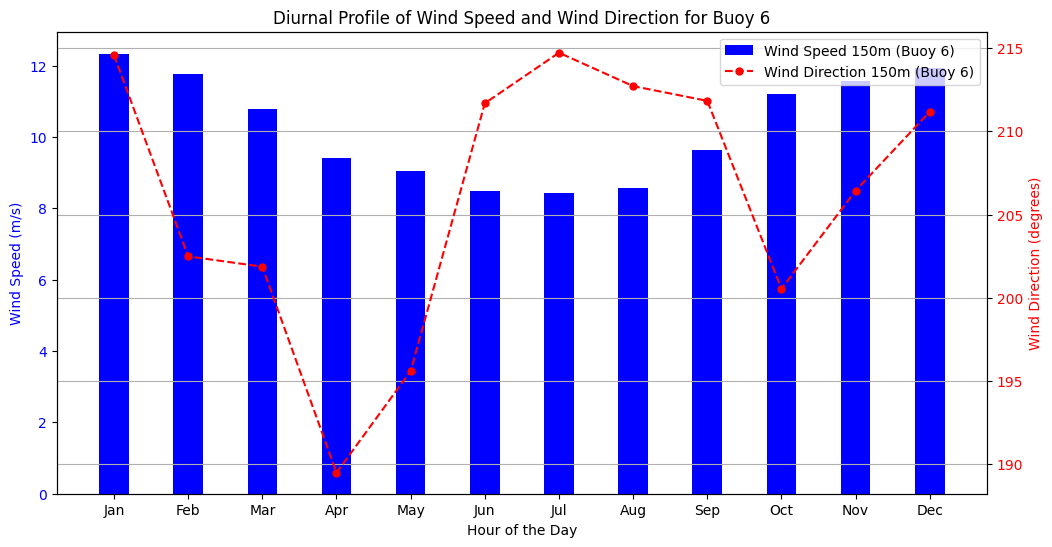

In [10]:
def plot_histogram_mounthly_mean(monthly_mean_ws, monthly_mean_wd):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot wind speed histogram on the left y-axis
    ax1.bar(months, monthly_mean_ws, width=0.4, label='Wind Speed 150m (Buoy 6)', color='b', align='center')
    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Wind Speed (m/s)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a second y-axis to plot wind direction
    ax2 = ax1.twinx()
    ax2.plot(months, monthly_mean_wd, 'r--o', label='Wind Direction 150m (Buoy 6)', markersize=5)
    ax2.set_ylabel('Wind Direction (degrees)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.title('Diurnal Profile of Wind Speed and Wind Direction for Buoy 6')
    plt.grid(True)
    plt.show()

plot_histogram_mounthly_mean(df_month_mean_B6['long-term_WS150'], df_month_mean_B6['long-term_WD150'])

#### 19. Group the data into hours of the day and calculate the mean wind speed and wind direction for each hour of the day
#### 20. Plot the diurnal wind speed and wind direction for both buoys

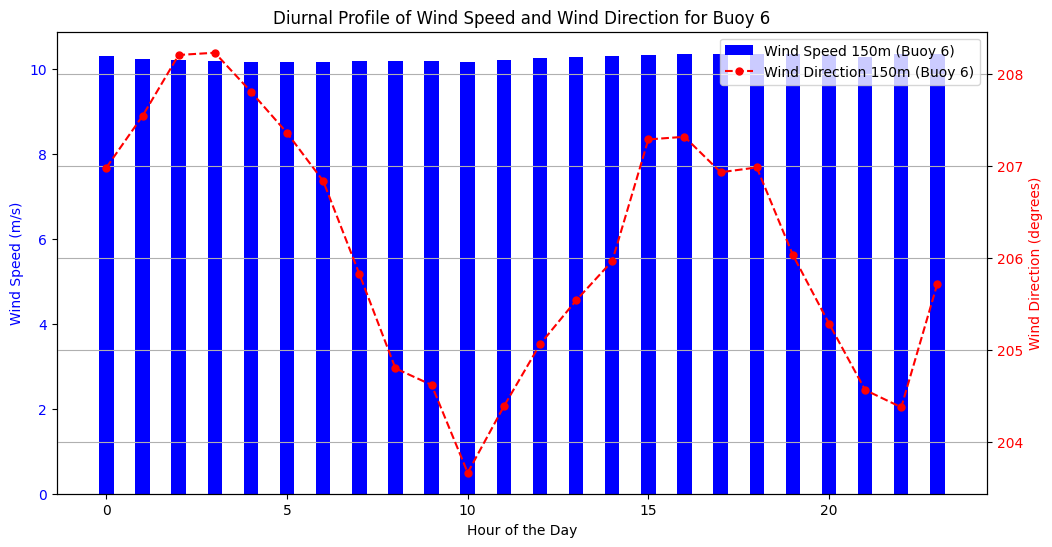

In [11]:
def calc_diurnal_wsand_wd(df):
        df.index = pd.to_datetime(df.index)
        df['hour'] = df.index.hour
        df_diurnal_WSWD = df.groupby('hour').mean()
        return df_diurnal_WSWD

def plot_dirunal_ws_and_wd(diurnal_index, diurnal_ws, diurnal_wd):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    # Plot wind speed histogram on the left y-axis
    ax1.bar(diurnal_index, diurnal_ws, width=0.4, label='Wind Speed 150m (Buoy 6)', color='b', align='center')
    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Wind Speed (m/s)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    # Create a second y-axis to plot wind direction
    ax2 = ax1.twinx()
    ax2.plot(diurnal_index, diurnal_wd, 'r--o', label='Wind Direction 150m (Buoy 6)', markersize=5)
    ax2.set_ylabel('Wind Direction (degrees)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.title('Diurnal Profile of Wind Speed and Wind Direction for Buoy 6')
    plt.grid(True)
    plt.show()

diurnal_B6_df = calc_diurnal_wsand_wd(df_B6)
plot_dirunal_ws_and_wd(diurnal_B6_df.index,  diurnal_B6_df['long-term_WS150'], diurnal_B6_df['long-term_WD150'])

In [12]:
diurnal_B6_df

,long-term_WS150,long-term_WD150,month
hour,,,
0,10.290878,206.980928,6.524478
1,10.228136,207.540611,6.524478
2,10.201378,208.202366,6.524478
3,10.182205,208.226854,6.524478
4,10.165095,207.803791,6.524478
5,10.160790,207.356174,6.524478
6,10.165564,206.834626,6.524478
7,10.172179,205.825965,6.524478
8,10.185793,204.801138,6.524478


#### 21. Plot wind roses for both buoys

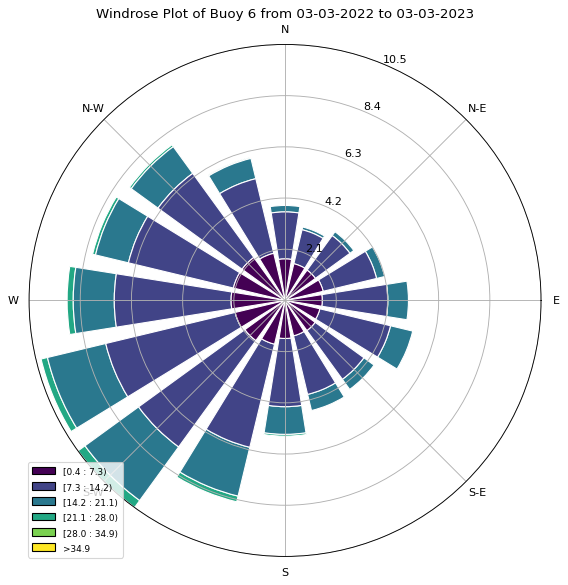

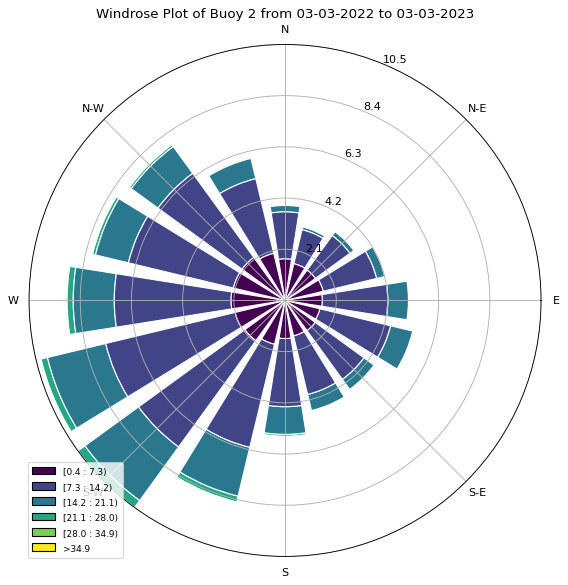

In [13]:

def plot_wind_rose(wd, ws, title):
    ax = WindroseAxes.from_ax()
    ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.title(title)
    plt.show()

plot_wind_rose(df_B6['long-term_WD150'], df_B6['long-term_WS150'], 'Windrose Plot of Buoy 6 from 03-03-2022 to 03-03-2023' )
plot_wind_rose(df_B2['long-term_WD150'], df_B2['long-term_WS150'], 'Windrose Plot of Buoy 2 from 03-03-2022 to 03-03-2023' )

#### 22. Plot a Weibull distribution of the wind speed

- weibull_min.fit(ws_data, floc=0): This part of the code fits a Weibull distribution to the wind speed data (ws_data). The fit method of the weibull_min distribution estimates the shape, location, and scale parameters of the Weibull distribution that best fit the provided data.
- shape, _, scale: The result of the fit method is a tuple containing the estimated parameters. In this case, shape represents the shape parameter of the Weibull distribution, and scale represents the scale parameter. The underscore _ is used to discard the estimated location parameter (floc), as it is fixed at 0 in this case.
- The weibull_pdf function defines the probability density function (PDF) for a Weibull distribution. function that describes the likelihood of a continuous random variable falling within a particular range of values.

#### 23. Calculate the annual power production of one turbine, one field, and the entire farm

Remark on wind turbine data: The "ct" in the turbine data refers to the thrust coefficient. It is a dimensionless number that describes the thrust force exerted by the wind on the turbine blades relative to the dynamic pressure of the wind.

APP of one Turbine: 85.2615 GWh
Estimated error: 0.0008 GWh
Annual Energy Production of N-9.1 (133 Turbines): 11.3398 TWh
Annual Energy Production of N-9.2 (133 Turbines): 11.3398 TWh
Annual Energy Production of N-9.3 (100 Turbines): 8.5262 TWh
Total Energy Production of all three fields (366 Turbines): 31.2057 TWh 
This is 6.15 % of the electricity consumed in one yr in Germany.


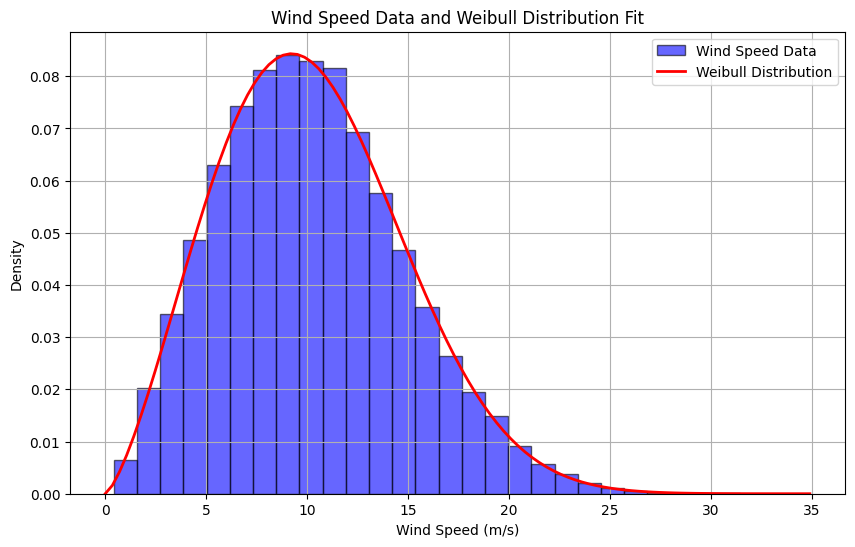

In [14]:
# Constants
T = 8760  # total hours/year [h]
rho = 1.225  # air density [kg/m^3]
D = 240  # rotor diameter [m]
A = np.pi * (D / 2)**2  # swept area [m^2]

# Load data
windspeed_data = df_B6['long-term_WS150']
power_curve_data = pd.read_csv(turbine_power_curve_path)

def cut_in_windspeed(power_curve_data):
    return power_curve_data.loc[power_curve_data['P'] > 0, 'ws'].min()

def cut_out_windspeed(power_curve_data):
    return power_curve_data.loc[power_curve_data['P'] > 0, 'ws'].max()

def power_curve_interpolated(power_curve_data):
    power_curve_func = interp1d(power_curve_data['ws'], power_curve_data['P'], fill_value="extrapolate")
    return power_curve_func

def calculate_weibull_fit(windspeed_data):
    shape, _, scale = weibull_min.fit(windspeed_data, floc=0)  # floc=0 => location parameter defaults to 0
    return shape, scale

def weibull_pdf(ws, shape, scale):
    return weibull_min.pdf(ws, shape, loc=0, scale=scale)

def integrand(ws, shape, scale, power_curve_func):
    P = power_curve_func(ws)  # Use interpolated power curve values
    return P * weibull_pdf(ws, shape, scale)

def calculate_APP(shape, scale, power_curve_func, cut_in_ws, cut_out_ws):
    APP, error = quad(integrand, cut_in_ws, cut_out_ws, args=(shape, scale, power_curve_func), limit=100, epsabs=1e-05, epsrel=1e-05)
    return APP * T, error * T  # Multiply by total hours per year to get AEP

# Process data
cut_in_ws = cut_in_windspeed(power_curve_data)
cut_out_ws = cut_out_windspeed(power_curve_data)
power_curve_func = power_curve_interpolated(power_curve_data)
shape, scale = calculate_weibull_fit(windspeed_data)

# Calculate APP (Annual Power Production)
APP, error = calculate_APP(shape, scale, power_curve_func, cut_in_ws, cut_out_ws)
print(f"APP of one Turbine: {APP / 1e6:.4f} GWh")  # Convert to MWh for readability
print(f"Estimated error: {error / 1e6:.4f} GWh")

total_farm_yield_no_wakes = ((APP/1e9) *366)

print(f"Annual Energy Production of N-9.1 (133 Turbines): {((APP/1e9) * turbines_N9_1):.4f} TWh")
print(f"Annual Energy Production of N-9.2 (133 Turbines): {((APP/1e9) * turbines_N9_2):.4f} TWh")
print(f"Annual Energy Production of N-9.3 (100 Turbines): {((APP/1e9) * turbines_N9_3):.4f} TWh")
print(f"Total Energy Production of all three fields (366 Turbines): {total_farm_yield_no_wakes:.4f} TWh ")
print(f"This is {((((APP/1e9) *366)/507)*100):.2f} % of the electricity consumed in one yr in Germany.")

# Plotting the Weibull distribution and wind speed data
plt.figure(figsize=(10, 6))
ws_range = np.linspace(0, max(windspeed_data), 100)
weibull_pdf_values = weibull_pdf(ws_range, shape, scale)

plt.hist(windspeed_data, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black', label='Wind Speed Data')
plt.plot(ws_range, weibull_pdf_values, 'r-', lw=2, label='Weibull Distribution')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.title('Wind Speed Data and Weibull Distribution Fit')
plt.legend()
plt.grid(True)
plt.show()


data = {
    'Energy Yield no wakes': [total_farm_yield_no_wakes]
}
df = pd.DataFrame(data)
df.to_csv('total_farmyield_nowakes.csv', index=False)


#### 24. Plot a power curve

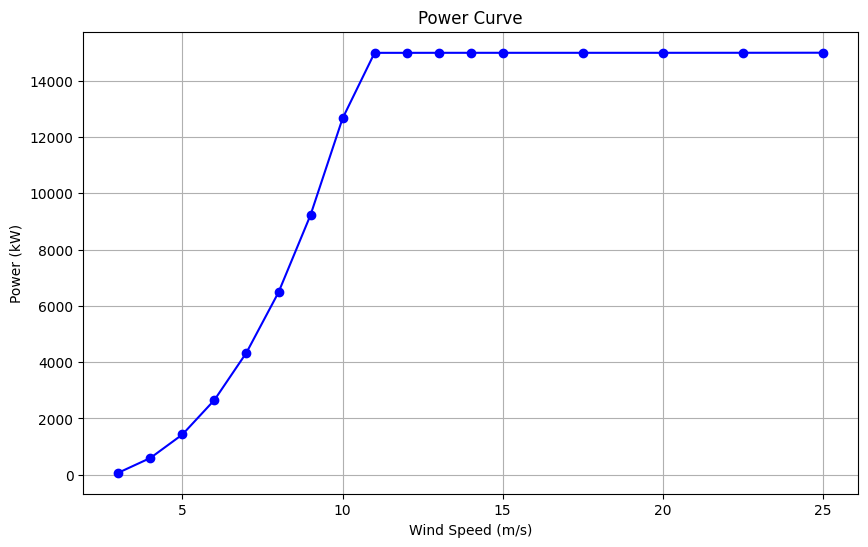

In [15]:
# Plotting the power curve
plt.figure(figsize=(10, 6))
plt.plot(power_curve_data['ws'], power_curve_data['P'], marker='o', linestyle='-', color='b')
plt.title('Power Curve')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.grid(True)
plt.show()